In [17]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import export_graphviz

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call
from IPython.display import Image


# Set the theme for the plots
sns.set_theme(style="whitegrid")

## Data


see the data_description.txt in Data folder


In [18]:
# Load the 1st 5 rows of the training data:
train = pd.read_csv(os.path.join("data", "train.csv"))
print(train.shape)
train.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [19]:
# Load the 1st 5 rows of the test data:
test = pd.read_csv(os.path.join("data", "test.csv"))
print(test.shape)
test.head()

(1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

## Data analysis

This code performs feature engineering on the Kaggle House Prices dataset, in order to prepare the data for further analysis and modeling to predict the sales price for each house.

In [20]:
# Display the statistics of the training data:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [21]:
# Display the data types and missing values in the training and test data :
print('Train info: \n')
print(train.info(), '\n')
print('Test info\n')
print(test.info())

Train info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  

In [22]:
# Define variables for identification, categorical features, numerical features, and the target variable:
id_feature = "Id"
# Categorical Features
categorical_features = train.select_dtypes(include = 'object').columns.tolist()
print(len(categorical_features))

# Continuous Features / Numerical Features
continuous_features = train.select_dtypes(include = ['float64', 'int64']).drop(columns = ['Id']).columns.tolist()
print(len(continuous_features))

# Target feature
target_feature = "SalePrice"

43
37


<Axes: xlabel='SalePrice', ylabel='Count'>

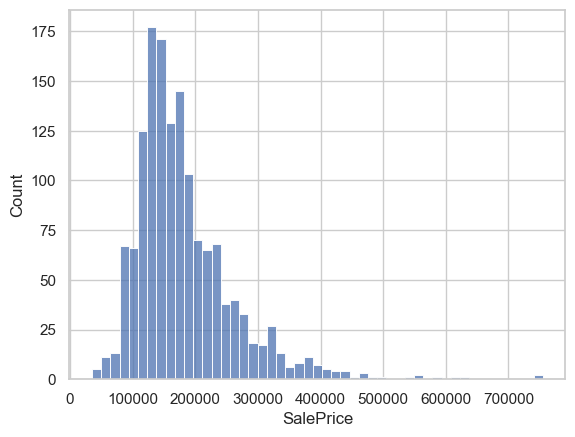

In [23]:
# Display the target feature distribution:
sns.histplot(train, x=target_feature)

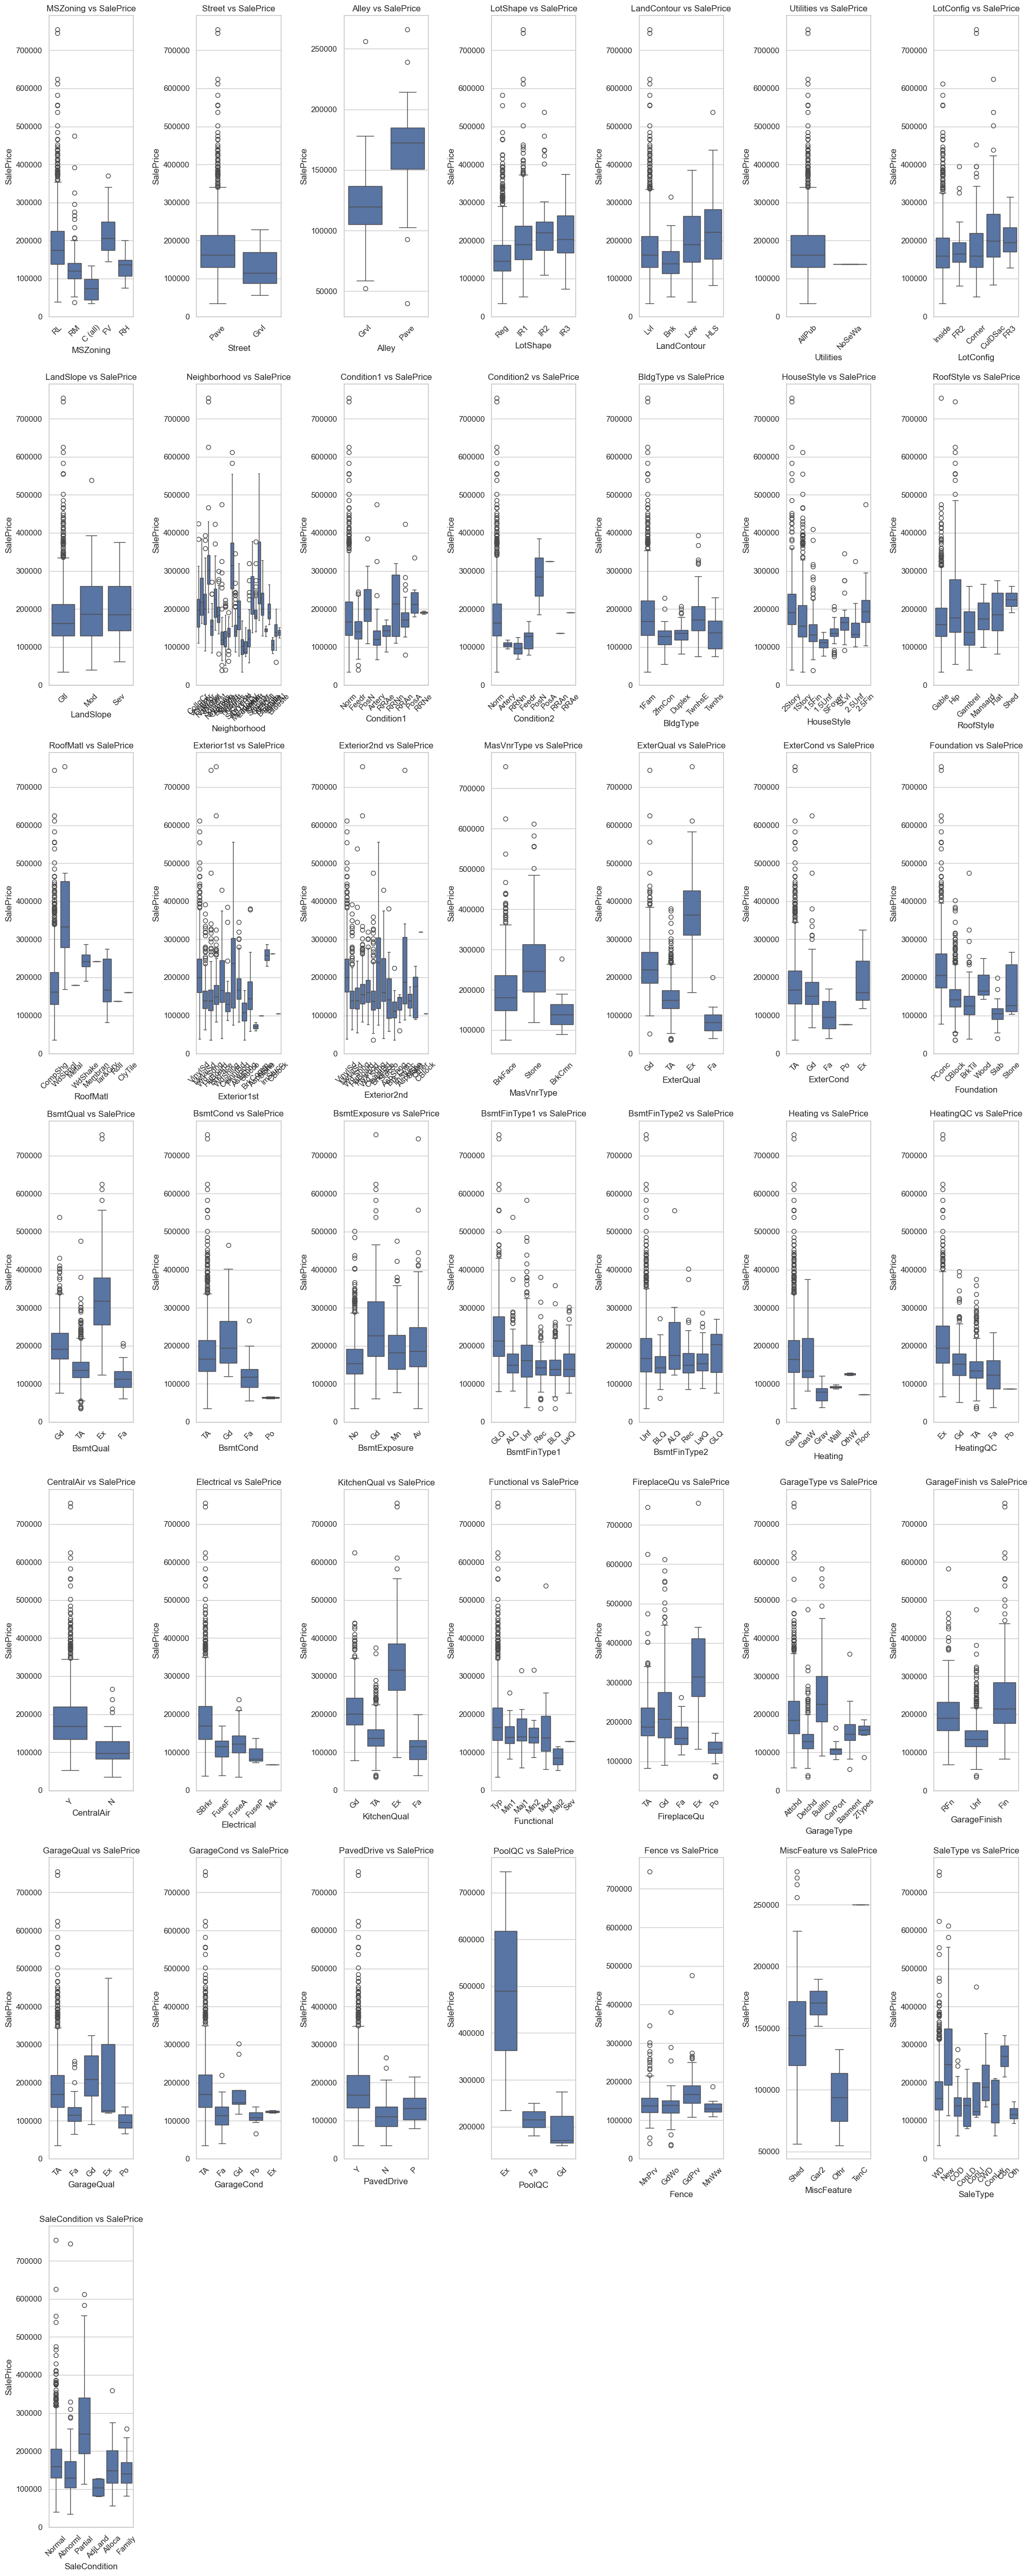

In [24]:
# Display the target feature distribution by the categorical features:
plt.figure(figsize=(20, len(categorical_features)//4*5))

# Loop through categorical features to create a boxplot for each
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(7, 7, i)  # Adjust the subplot grid based on the number of features
    sns.boxplot(data=train, x=feature, y=target_feature)
    plt.title(f'{feature} vs {target_feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


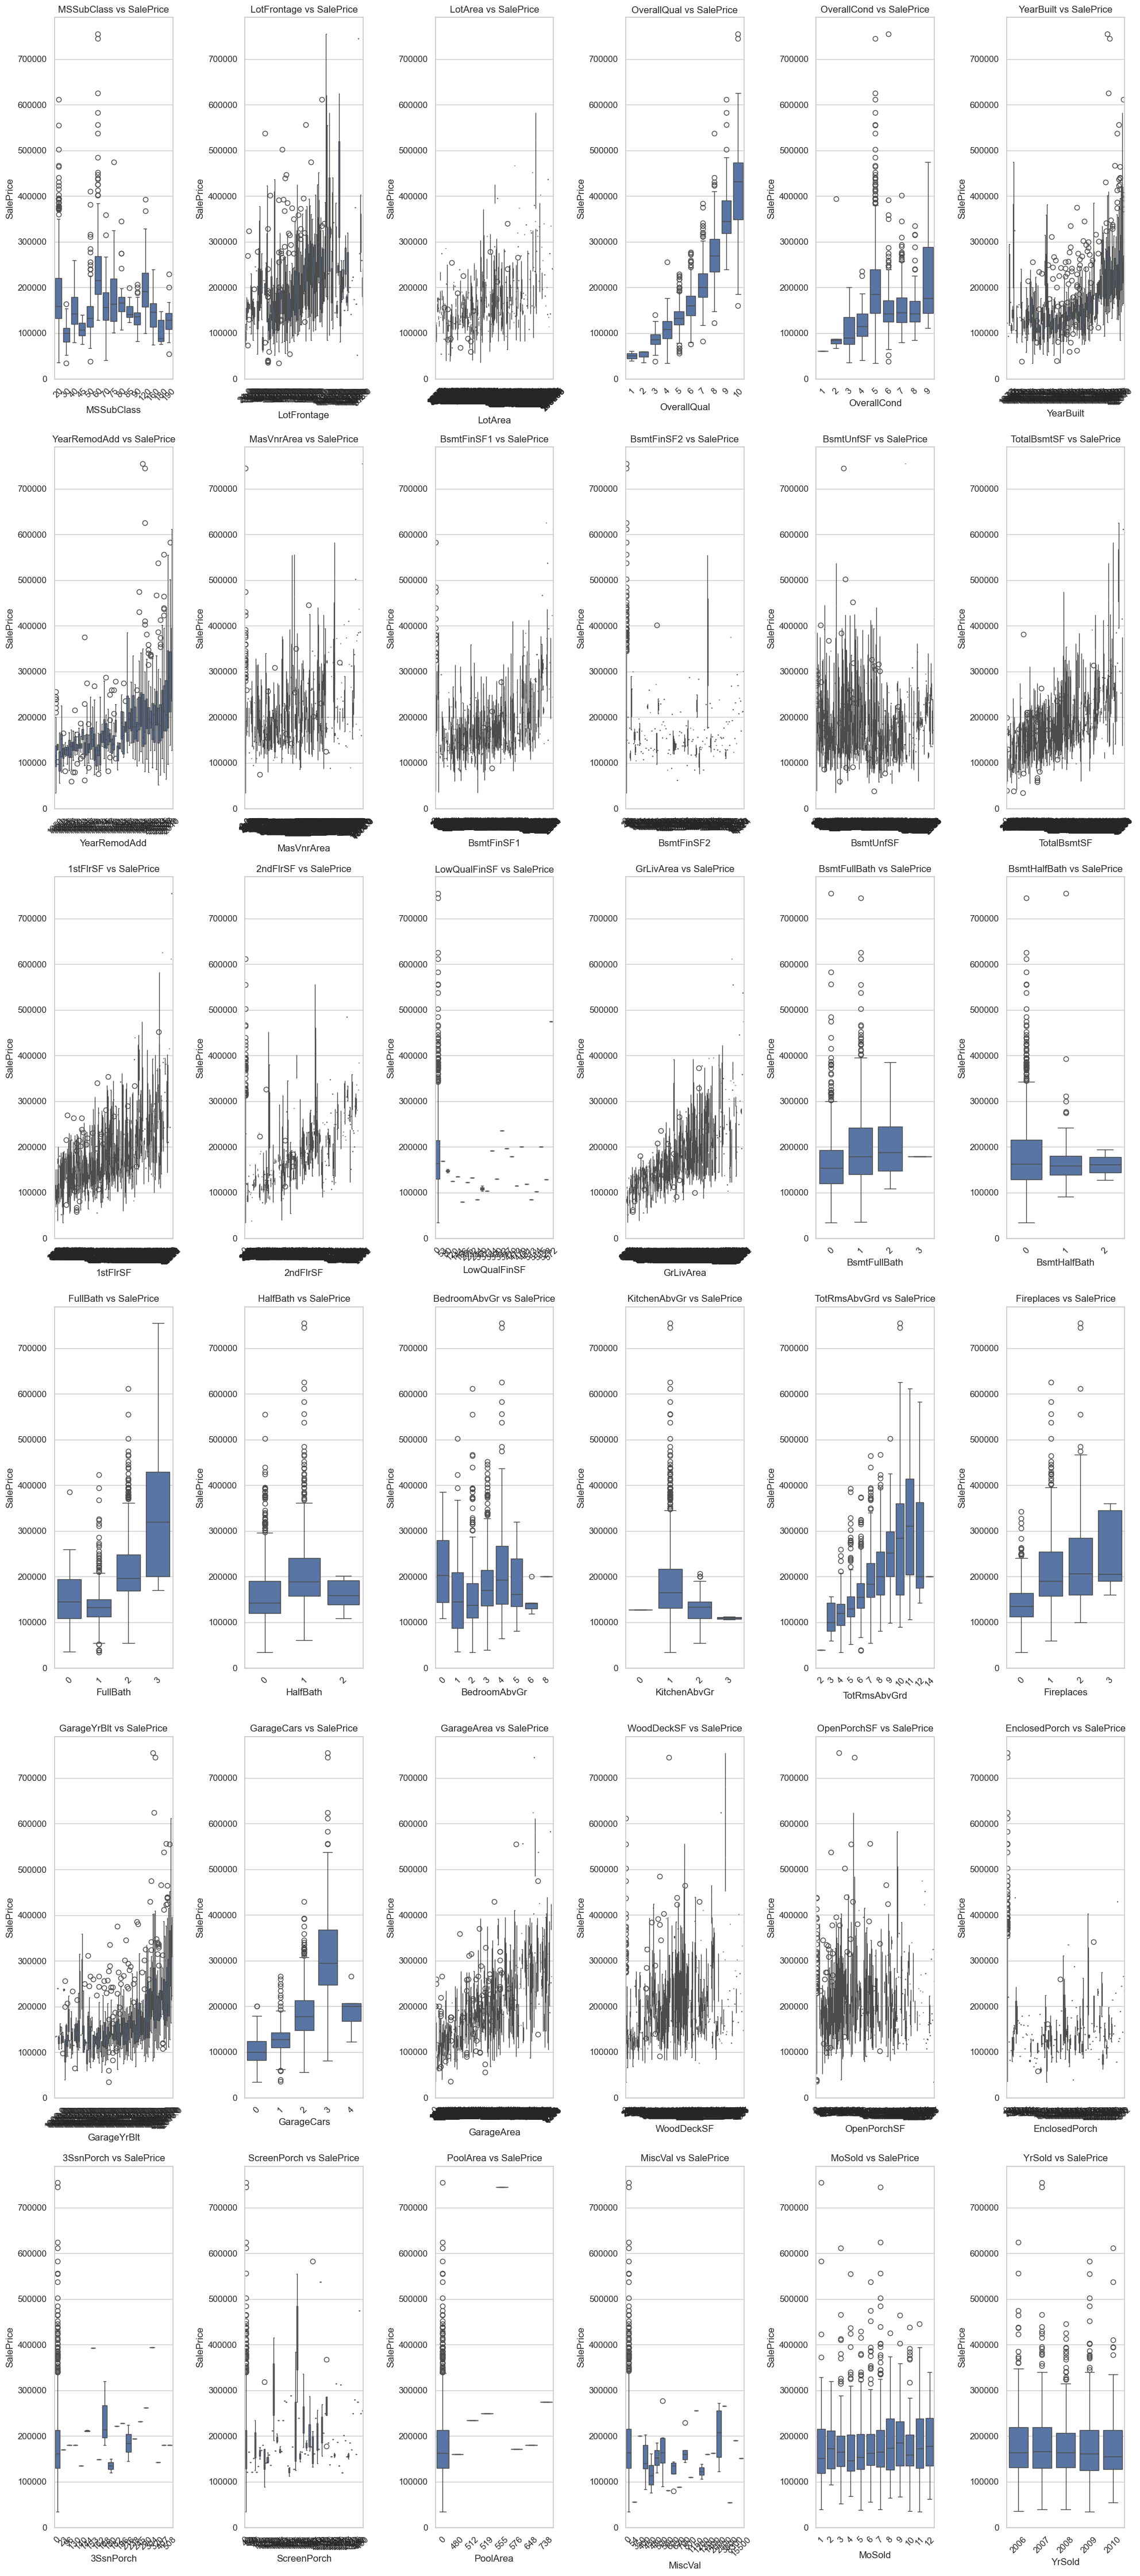

In [25]:
# Display the target feature distribution by the continuous features:
continuous_features.remove(target_feature)  # Remove the target feature from the list of continuous features
plt.figure(figsize=(20, len(continuous_features) // 4 * 5))  # Adjust height proportionally to the number of features

# Loop through continuous features to create a scatterplot for each
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(6, 6, i)  
    sns.boxplot(data=train, x=feature, y=target_feature)
    plt.title(f'{feature} vs {target_feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<Axes: >

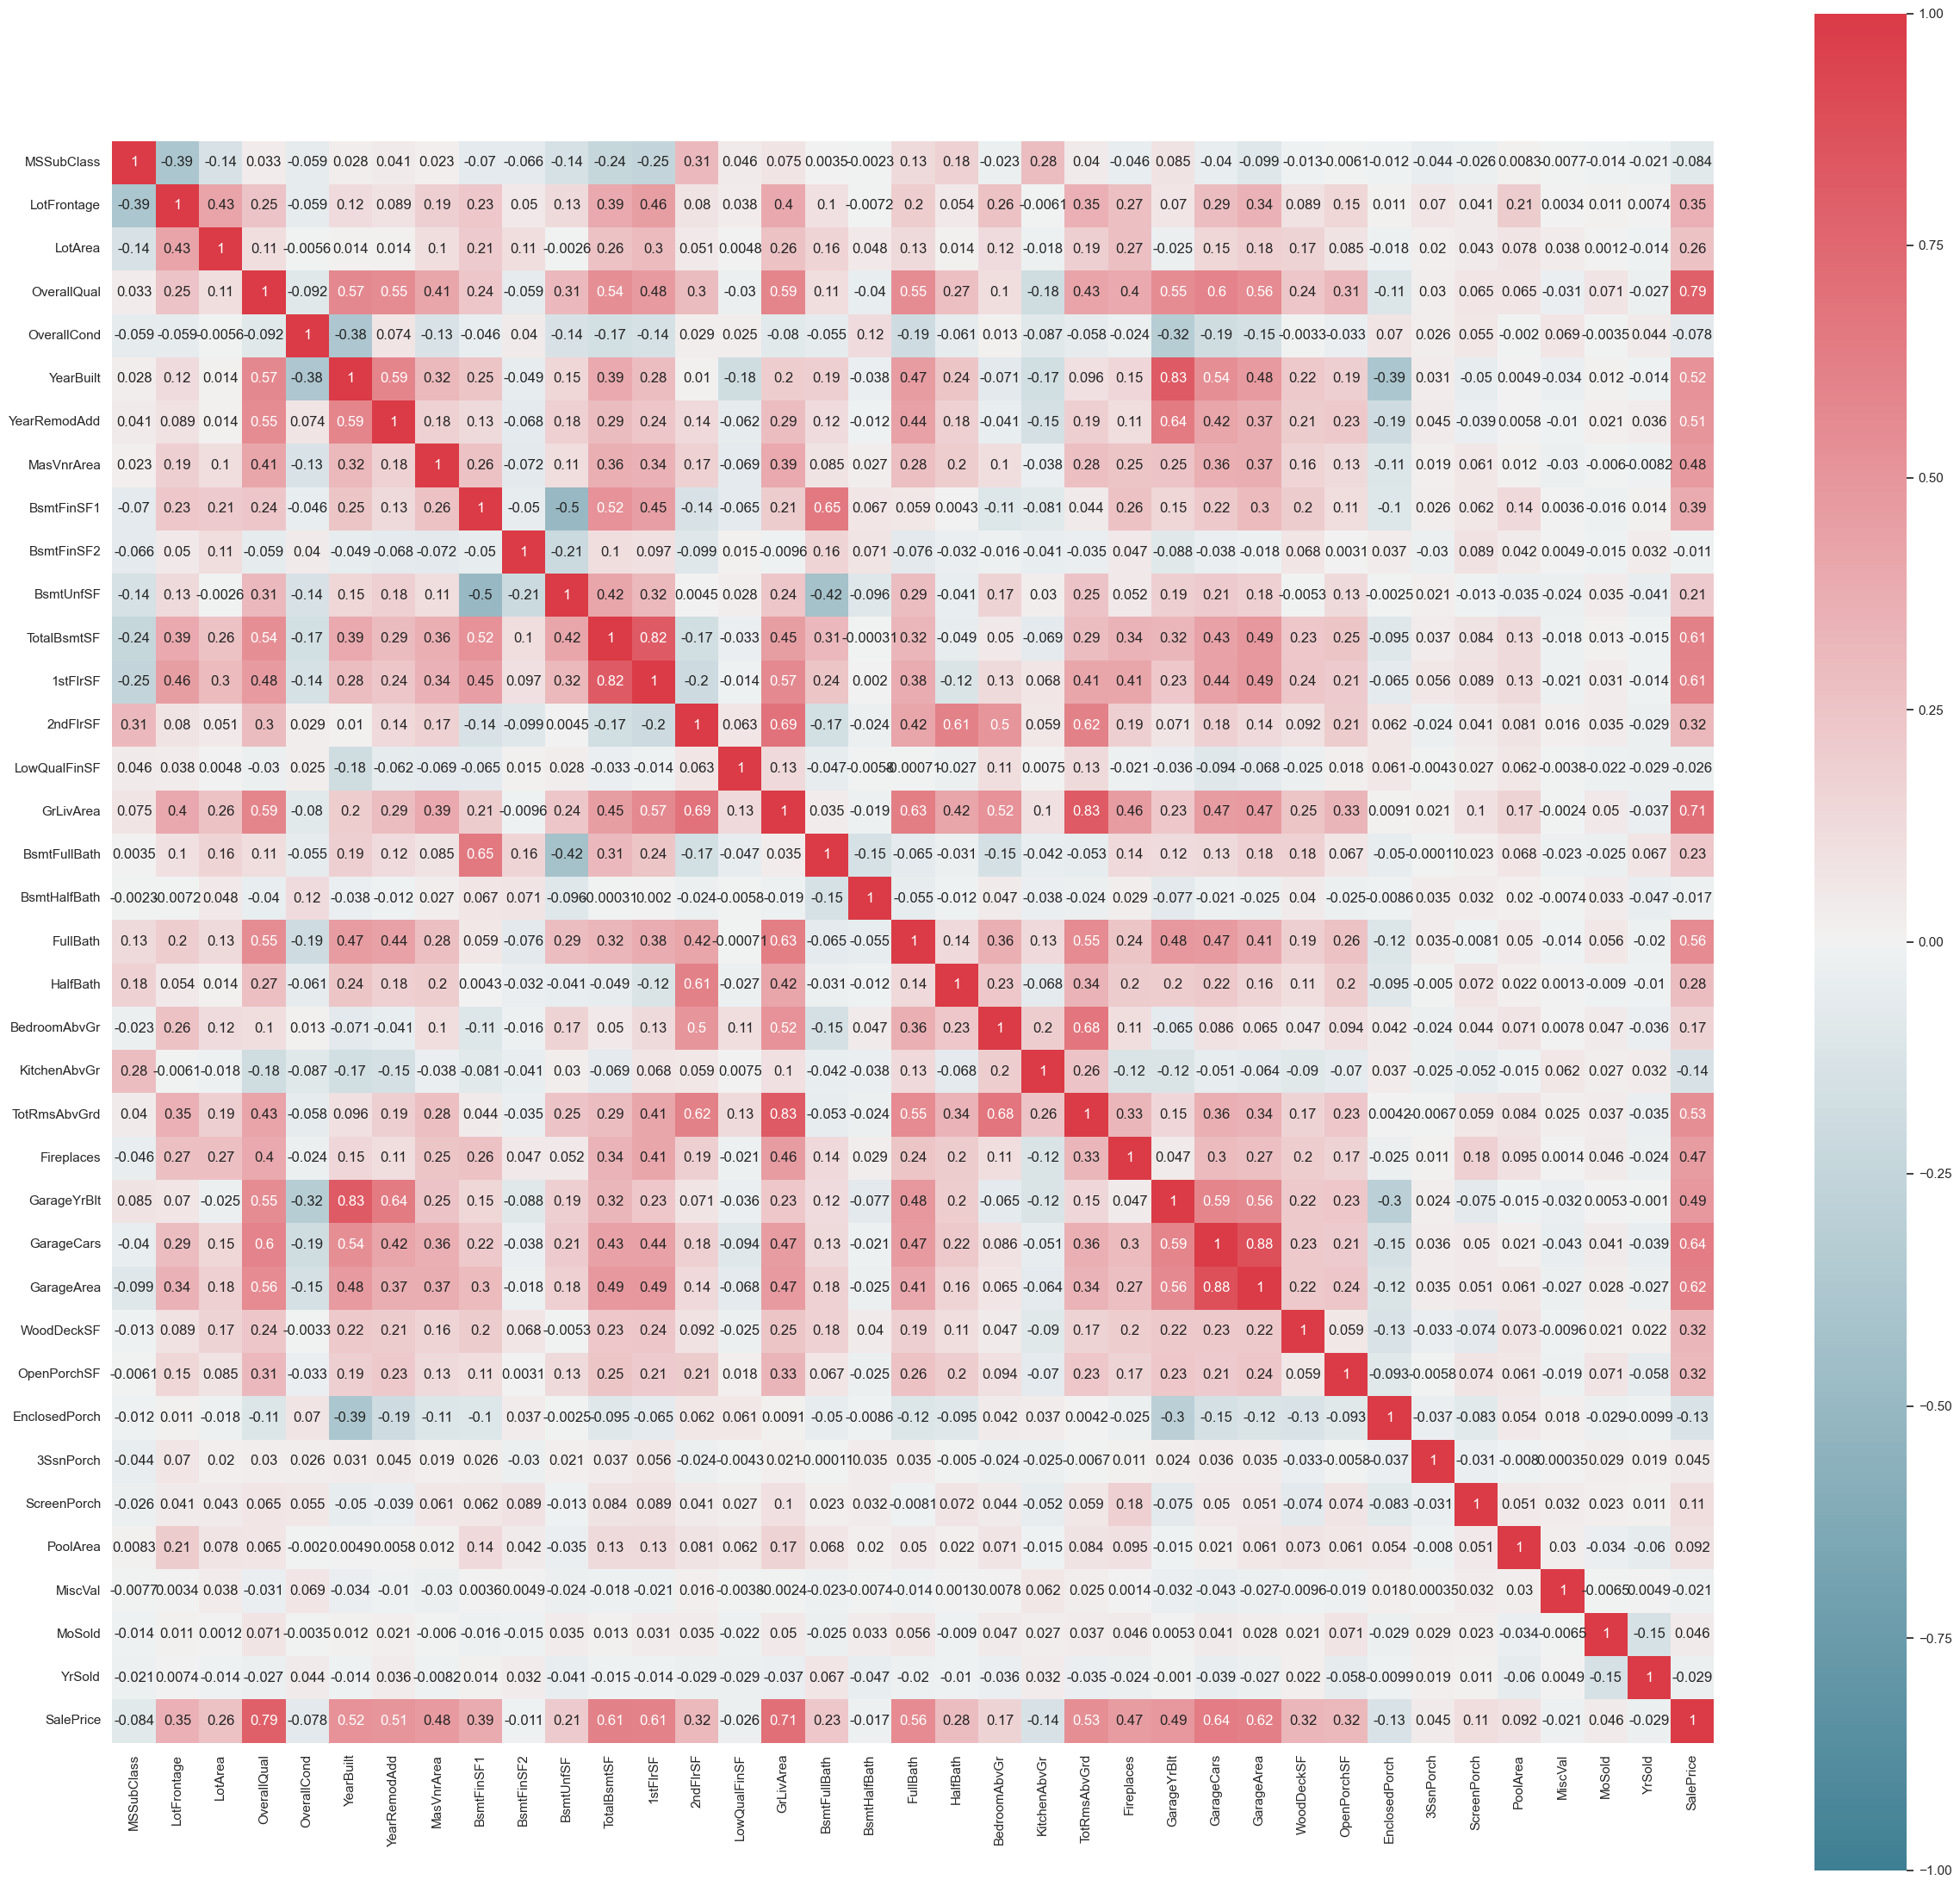

In [26]:
# Display the correlation between the continuous features:
corr = train[train.select_dtypes(include = ['float64', 'int64']).drop(columns = ['Id']).columns.tolist()].corr() 

# Plot the correlation matrix:
f, ax = plt.subplots(figsize=(30, 28))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0, square=True, ax=ax, annot=True)

In [27]:
# Features with the correlation lower than 0.1:
low_corr_features = corr[(corr[target_feature] < 0.1) & (corr[target_feature] > -0.1)].index.tolist()
print(low_corr_features)

['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


### Feature engineering

In [28]:
# Concatenate the training and test data for preprocessing:
dataset = pd.concat([train, test]).reset_index(drop=True)

# Display the data types and missing values in the combined data:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

##### Handle Missing Values

In [29]:
# Categorical Features:
# Drop columns with too many missing values:
dataset = dataset.drop(columns=["Alley","PoolQC", "Fence", "MiscFeature"])
categorical_features = [feature for feature in categorical_features if feature not in ["Alley","PoolQC", "Fence", "MiscFeature"]]

# Fill missing values with 'None' or 'Unknown' if the feature represents a specific category:
dataset = dataset.fillna({feature: "None" for feature in categorical_features})
dataset[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2919 non-null   object
 1   Street         2919 non-null   object
 2   LotShape       2919 non-null   object
 3   LandContour    2919 non-null   object
 4   Utilities      2919 non-null   object
 5   LotConfig      2919 non-null   object
 6   LandSlope      2919 non-null   object
 7   Neighborhood   2919 non-null   object
 8   Condition1     2919 non-null   object
 9   Condition2     2919 non-null   object
 10  BldgType       2919 non-null   object
 11  HouseStyle     2919 non-null   object
 12  RoofStyle      2919 non-null   object
 13  RoofMatl       2919 non-null   object
 14  Exterior1st    2919 non-null   object
 15  Exterior2nd    2919 non-null   object
 16  MasVnrType     2919 non-null   object
 17  ExterQual      2919 non-null   object
 18  ExterCond      2919 non-null

In [30]:
# Continuous Features:
# Imputing missing values for LotFrontage (linear feet of street connected to the property) using a related feature like Neighborhood
# leverages the idea that properties in the same neighborhood often have similar characteristics:
dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Handle the remaining missing values by filling them with the mean:
dataset["LotFrontage"] = dataset["LotFrontage"].fillna(dataset["LotFrontage"].mean())

# Fill missing values with the median or mean, depending on the distribution:
dataset = dataset.fillna({feature: dataset[feature].mean() for feature in continuous_features})

In [31]:
# Transform Categorical Features:

# Use one-hot encoding for nominal categorical features.
# Identify nominal categorical features with fewer than 4 unique values
nominal_features = dataset[categorical_features].nunique()[dataset[categorical_features].nunique() < 4].keys().tolist()

# Initialize OneHotEncoder with drop='first' to avoid multicollinearity
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Perform one-hot encoding on the nominal features
encoded_data = encoder.fit_transform(dataset[nominal_features])

# Create a DataFrame for the encoded features with appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(nominal_features), index=dataset.index)

# Drop the original nominal features and concatenate the encoded features
dataset = pd.concat([dataset.drop(columns=nominal_features), encoded_df], axis=1)

# Use label encoding if the categories have a meaningful order
ordinal_features = [feature for feature in categorical_features if feature not in nominal_features]
label_encoder = LabelEncoder()
for feature in ordinal_features:
    dataset[feature] = label_encoder.fit_transform(dataset[feature])


In [32]:
# Using methods such as scaler/transformers

scaler = StandardScaler(copy=False, with_mean=True)

scaler.fit_transform(dataset)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                2919 non-null   int64  
 1   MSSubClass        2919 non-null   int64  
 2   MSZoning          2919 non-null   int64  
 3   LotFrontage       2919 non-null   float64
 4   LotArea           2919 non-null   int64  
 5   LotShape          2919 non-null   int64  
 6   LandContour       2919 non-null   int64  
 7   LotConfig         2919 non-null   int64  
 8   Neighborhood      2919 non-null   int64  
 9   Condition1        2919 non-null   int64  
 10  Condition2        2919 non-null   int64  
 11  BldgType          2919 non-null   int64  
 12  HouseStyle        2919 non-null   int64  
 13  OverallQual       2919 non-null   int64  
 14  OverallCond       2919 non-null   int64  
 15  YearBuilt         2919 non-null   int64  
 16  YearRemodAdd      2919 non-null   int64  


In [33]:
# Split the data back into training and test sets:
train = dataset.loc[dataset["SalePrice"].notnull(), :]
test = dataset.loc[dataset["SalePrice"].isnull(), :]

print(train.shape, test.shape)

(1460, 80) (1459, 80)


In [34]:
# Define the features for training:
training_features = [col for col in train.columns if col != target_feature and col != 'Id']
training_features

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',


In [35]:
# Create an array X and y for the training and X_test for the test data:
X = train[training_features]
y = train[target_feature]

X.shape, y.shape

((1460, 78), (1460,))

In [36]:
X_test = test[training_features]
y_test = test[target_feature]
y_test.shape, X_test.shape

((1459,), (1459, 78))

### Model Implementation

In [37]:
# Train a tree-based model:
def train_tree_model(X, y, model, params):
    """
    Train a tree-based model.

    Args:
        X (pd.DataFrame): input feature examples, size (n_examples, n_features)
        y (pd.Series): labels, size (n_examples,)
        model: a tree-based model
        params (dict): GridSearchCV's parameters
    Returns:
        model (sklearn, xgboost or lightgbm): a trained tree-based model
    """

     # Set a cross-validation strategy:
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Split the data
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize the GridSearch model
    grid_model = GridSearchCV(model, params, cv=cv_strategy, scoring="neg_root_mean_squared_error")

    # Train the GridSearch model
    grid_model.fit(X_train, y_train)

    # Get the best classifier
    model = grid_model.best_estimator_

      # Display the best estimator, score and parameters
    print("BEST ESTIMATOR:")
    print(f"{model}\n")
    print(f"Mean cross-validated score of the best estimator: {grid_model.best_score_:.3f}\n")
    print(f"Best parameters: {grid_model.best_params_}\n")

    # Obtain and display test error
    y_dev_pred = model.predict(X_dev)
    print(f"Validation RMSE: {root_mean_squared_error(y_dev, y_dev_pred):.3f}\n")

    # Display feature importance
    print("FEATURE IMPORTANCE:")

    # Analyze the TOP 30 feature importances:
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature = list(X)
        sorted_idx = np.argsort(importances)[::-1][:30]  # Indices to sort by descending importance, TOP 30 features

        # Plot TOP 30 feature importances
        plt.figure(figsize=(30, 28))
        sns.barplot(x=np.array(importances)[sorted_idx], y=np.array(feature)[sorted_idx], color="b")  # Correct indexing
        plt.title("Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
    else:
        print("Feature importance is not available for this model.")

    # Compute RMSE for different `n_estimators`
    if "n_estimators" in params:
        n_trees = params["n_estimators"]
        rmse_values = []

        for n in n_trees:
            # Train a fresh model with different `n_estimators`
            temp_model = model.set_params(n_estimators=n)
            temp_model.fit(X_train, y_train)

            # Predict on validation set
            y_dev_pred = temp_model.predict(X_dev)

            # Compute RMSE
            rmse = root_mean_squared_error(y_dev, y_dev_pred)
            rmse_values.append(rmse)

        # Plot RMSE vs. Number of Trees
        plt.figure(figsize=(10, 6))
        plt.plot(n_trees, rmse_values, marker='o', linestyle='-', color='b')
        plt.xlabel("Number of Trees")
        plt.ylabel("RMSE")
        plt.title("RMSE vs. Number of Trees")
        plt.grid(True)
        plt.show()


    return model

#### Random Forest

BEST ESTIMATOR:
RandomForestRegressor(n_estimators=125, oob_score=True, random_state=42)

Mean cross-validated score of the best estimator: -28757.079

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}

Validation RMSE: 33299.879

FEATURE IMPORTANCE:


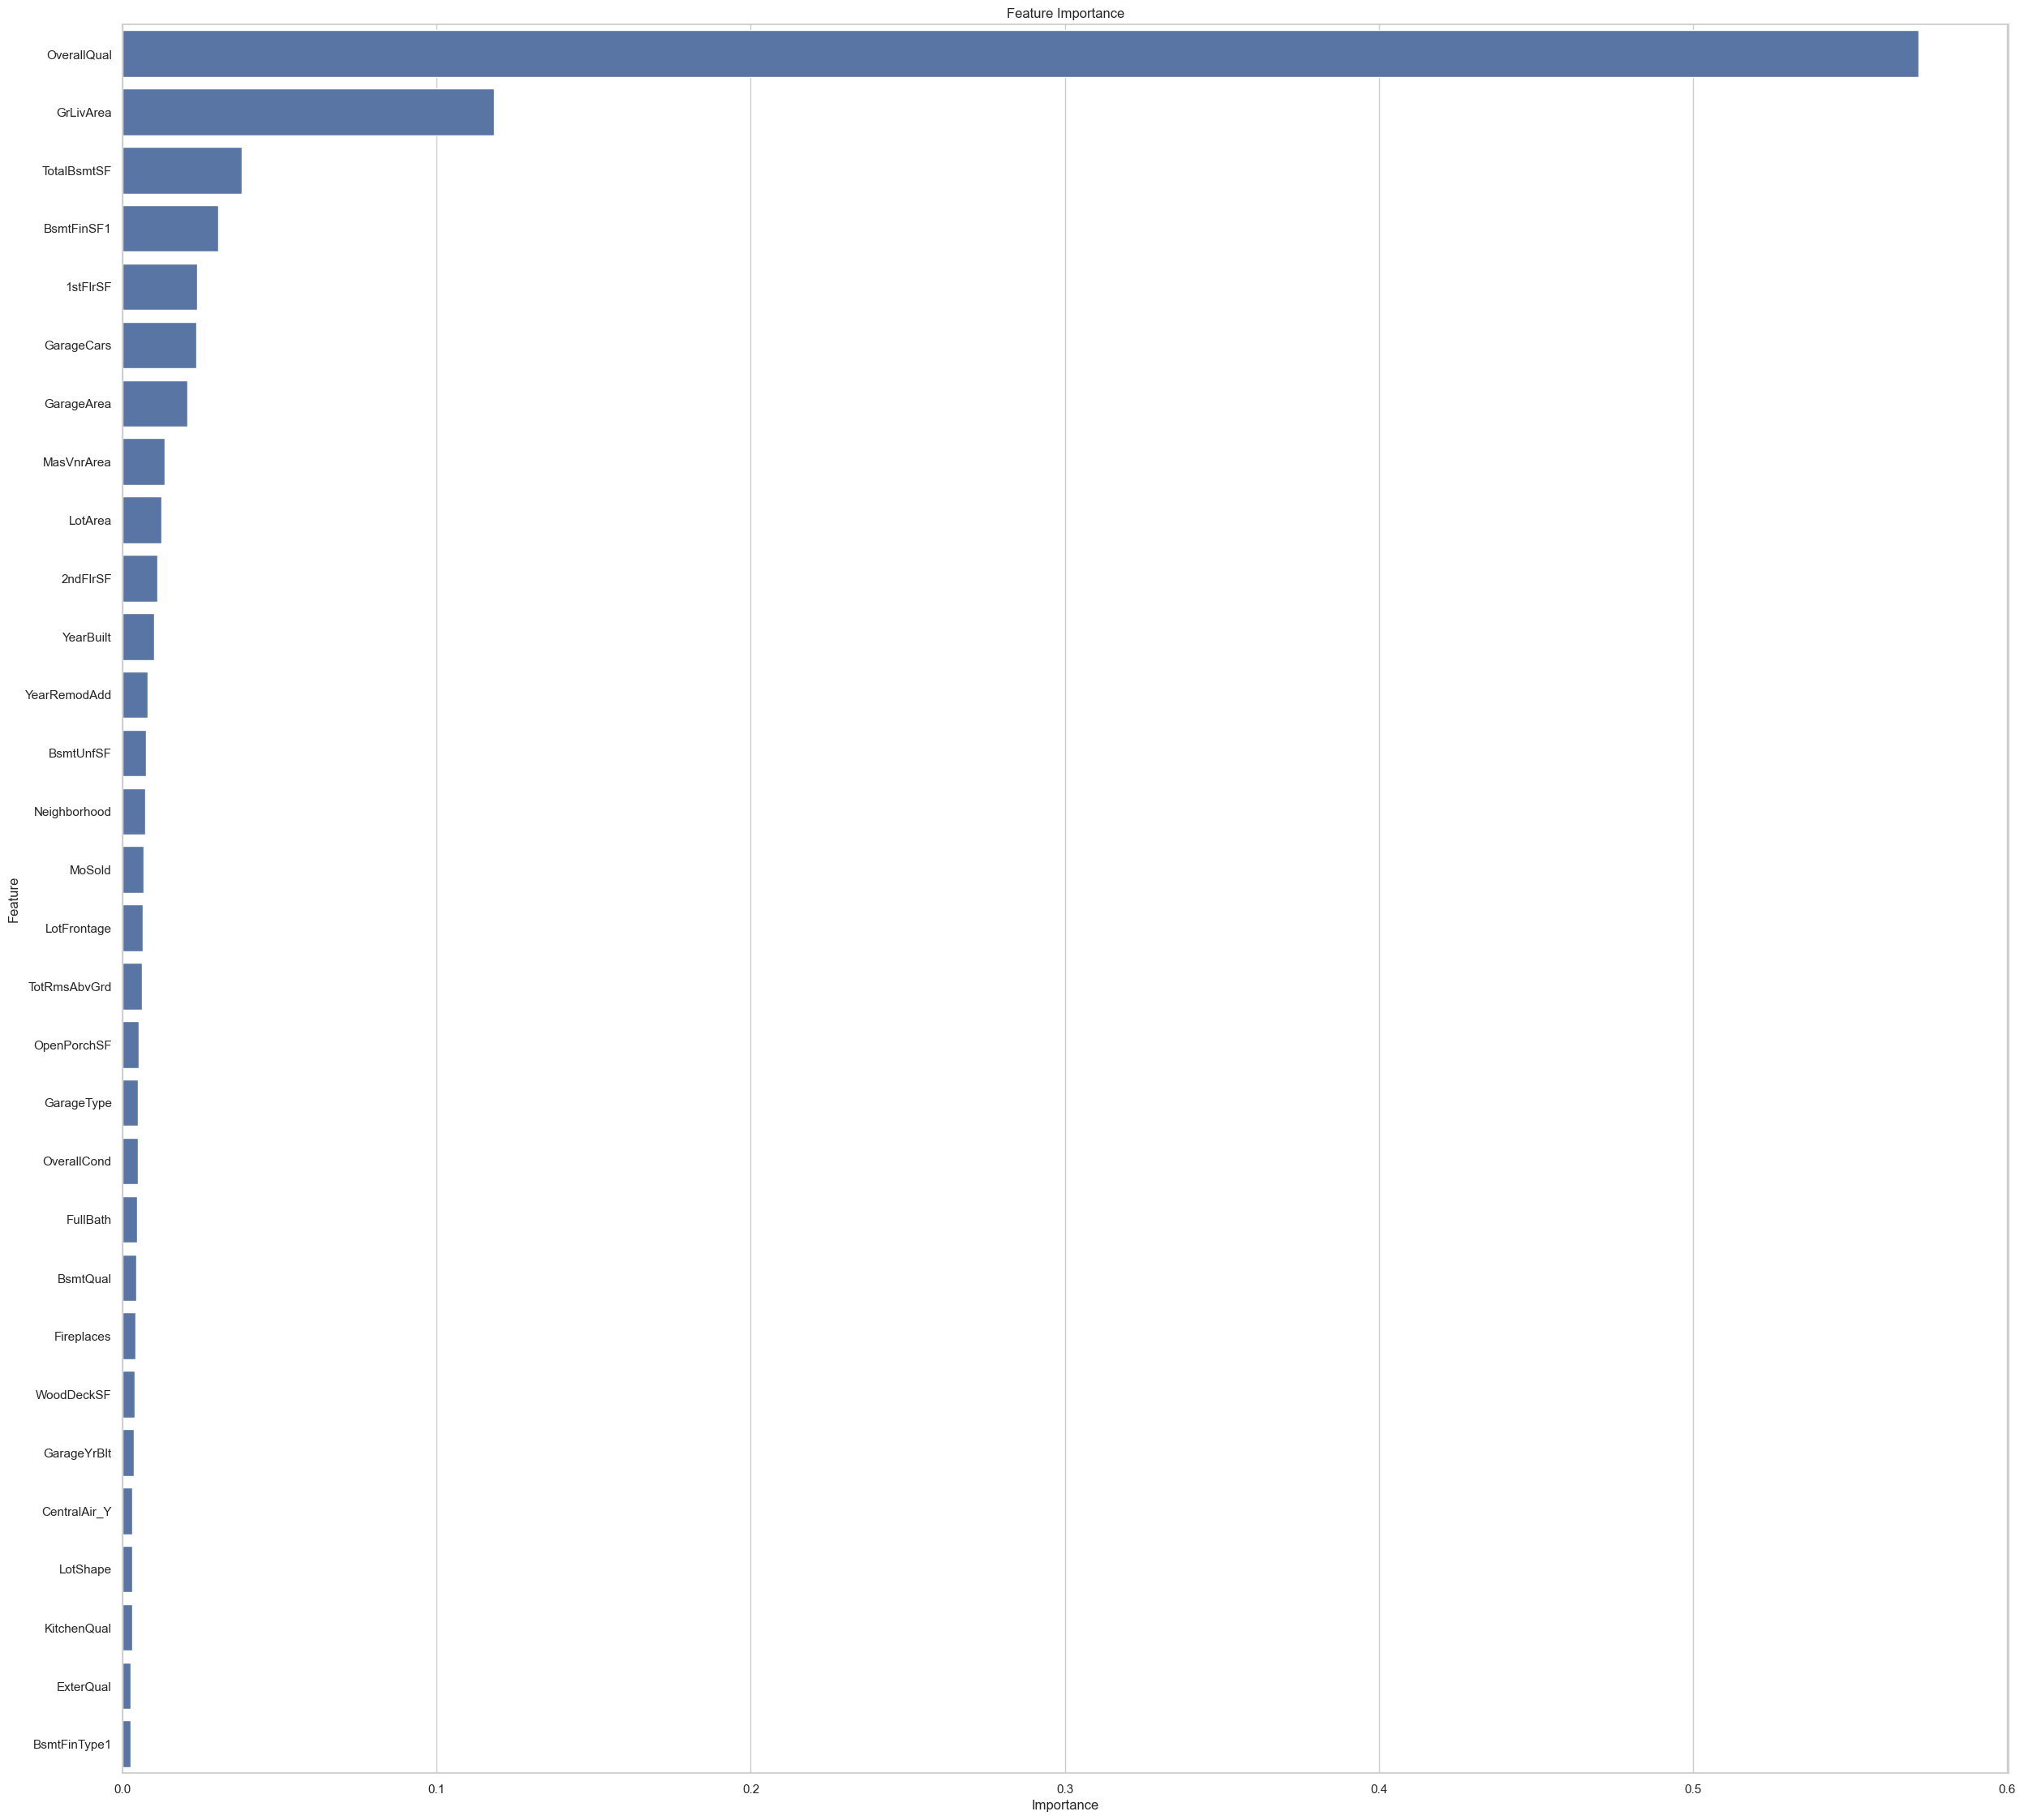

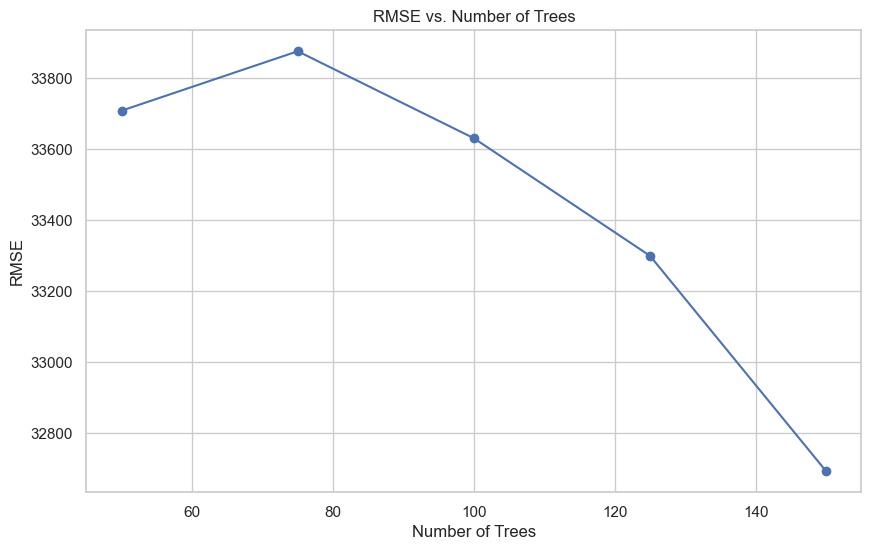

In [38]:
# Random Forest Regressor:
rf_model = RandomForestRegressor(criterion='squared_error', oob_score=True, random_state=42)

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [50, 75, 100, 125, 150],
          'min_samples_split': [2, 4, 8, 16, 20],
          'min_samples_leaf': [1, 4, 8, 12, 16]
          }

# Train the model
rf_model_best = train_tree_model(X, y, rf_model, params)

In [39]:
# Export the 15th tree as dot file
export_graphviz(rf_model_best.estimators_[15], out_file='tree.dot',
                feature_names = training_features,
                class_names = None,
                rounded = True,
                proportion = False,
                precision = 2,
                filled = True)

# Convert to png using system command
graphviz_path = r"C:\Program Files\Graphviz\bin\dot.exe"
call([graphviz_path, '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=300'])

# Display the tree
Image(filename = 'tree.png')

#### LightGBM

c:\Users\delem\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


BEST ESTIMATOR:
LGBMRegressor(max_depth=3, min_data_in_leaf=20, n_estimators=200, num_leaves=5,
              verbose=-100)

Mean cross-validated score of the best estimator: -26271.478

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 20, 'n_estimators': 200, 'num_leaves': 5}

Validation RMSE: 31529.853

FEATURE IMPORTANCE:


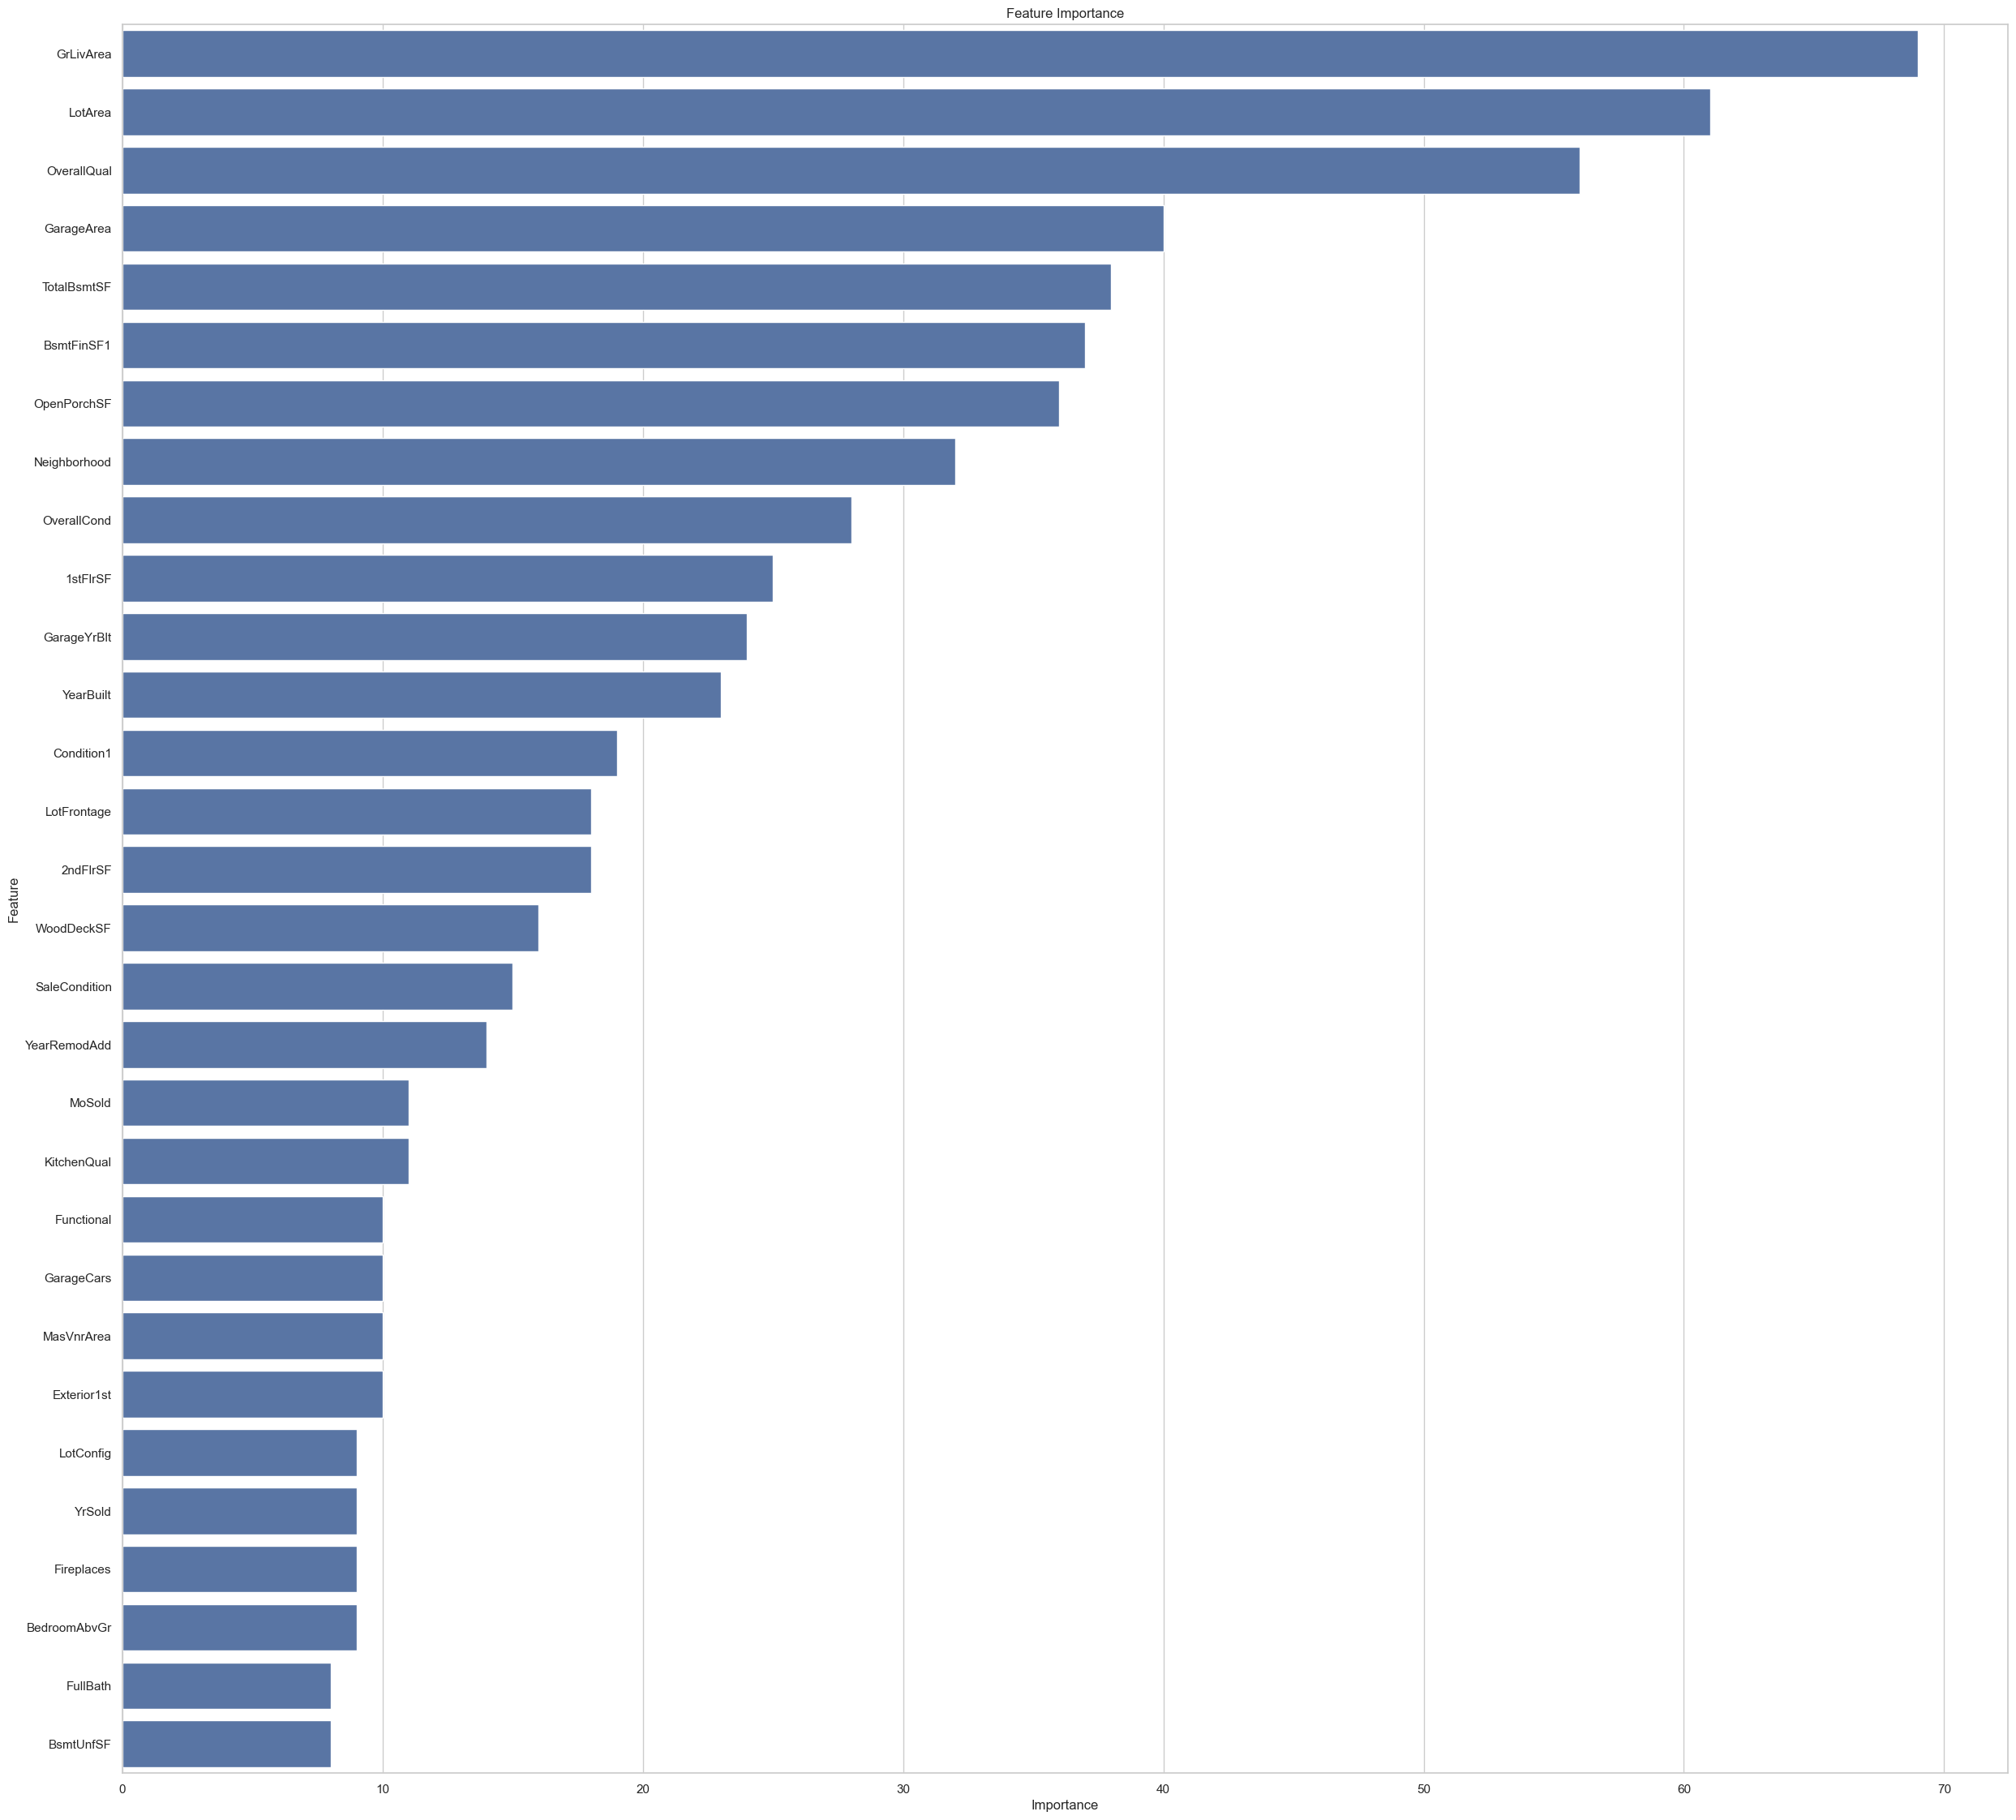

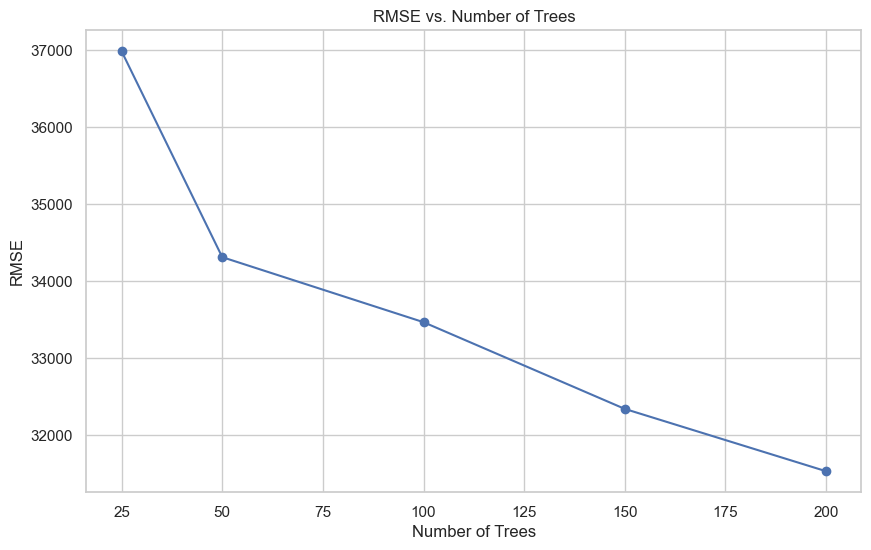

In [40]:
# LightGBM Regressor:
lgbm_model = lgb.LGBMRegressor(verbose=-100)

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [25, 50, 100, 150, 200],
          'learning_rate': [0.1, 0.01, 0.001, 0.0001],
          'num_leaves': [5, 10, 15],
          'min_data_in_leaf': [20, 30],
          'max_depth': range(3, 8)
          }

# Train the model
lgbm_model_best = train_tree_model(X, y, lgbm_model, params)

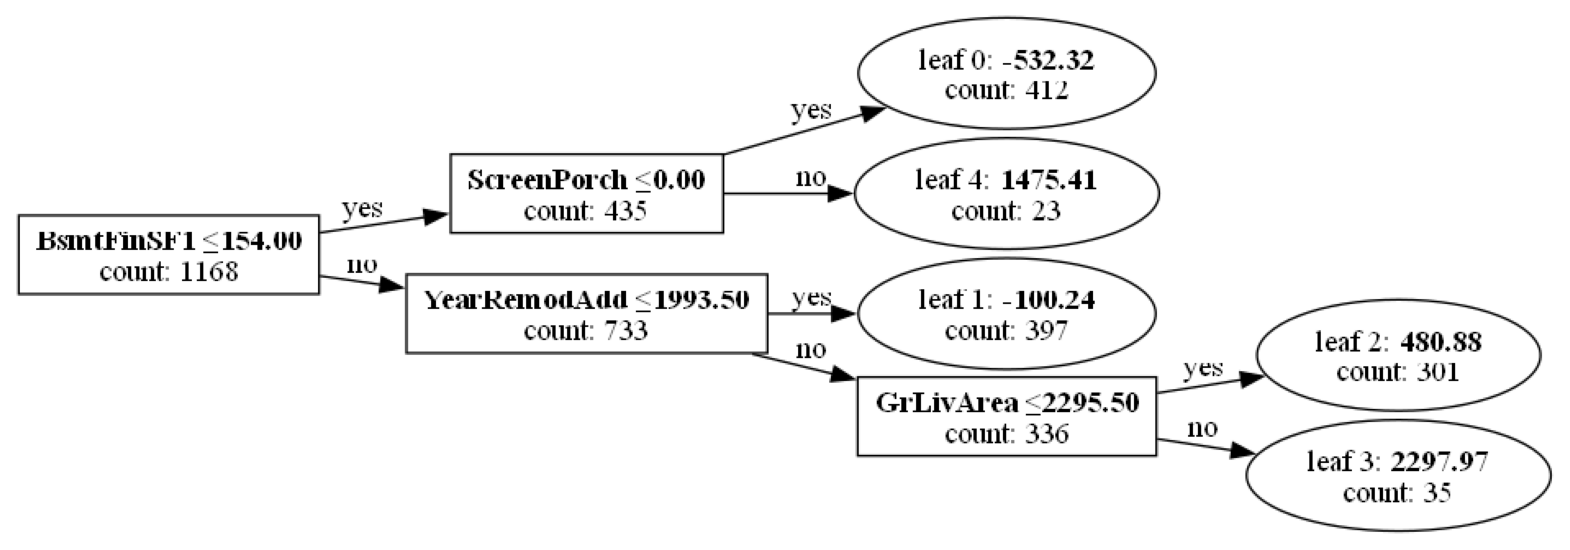

In [41]:
# Plot 45th decision tree of the LightGBM model
ax = lgb.plot_tree(lgbm_model_best, tree_index=45, figsize=(20, 10), precision=2, show_info=['internal_count', 'leaf_count'])
plt.show()

#### Gradient Boosted Trees

BEST ESTIMATOR:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Mean cross-validated score of the best estimator: -27410.932

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

Validation RMSE: 29445.128

FEATURE IMPORTANCE:


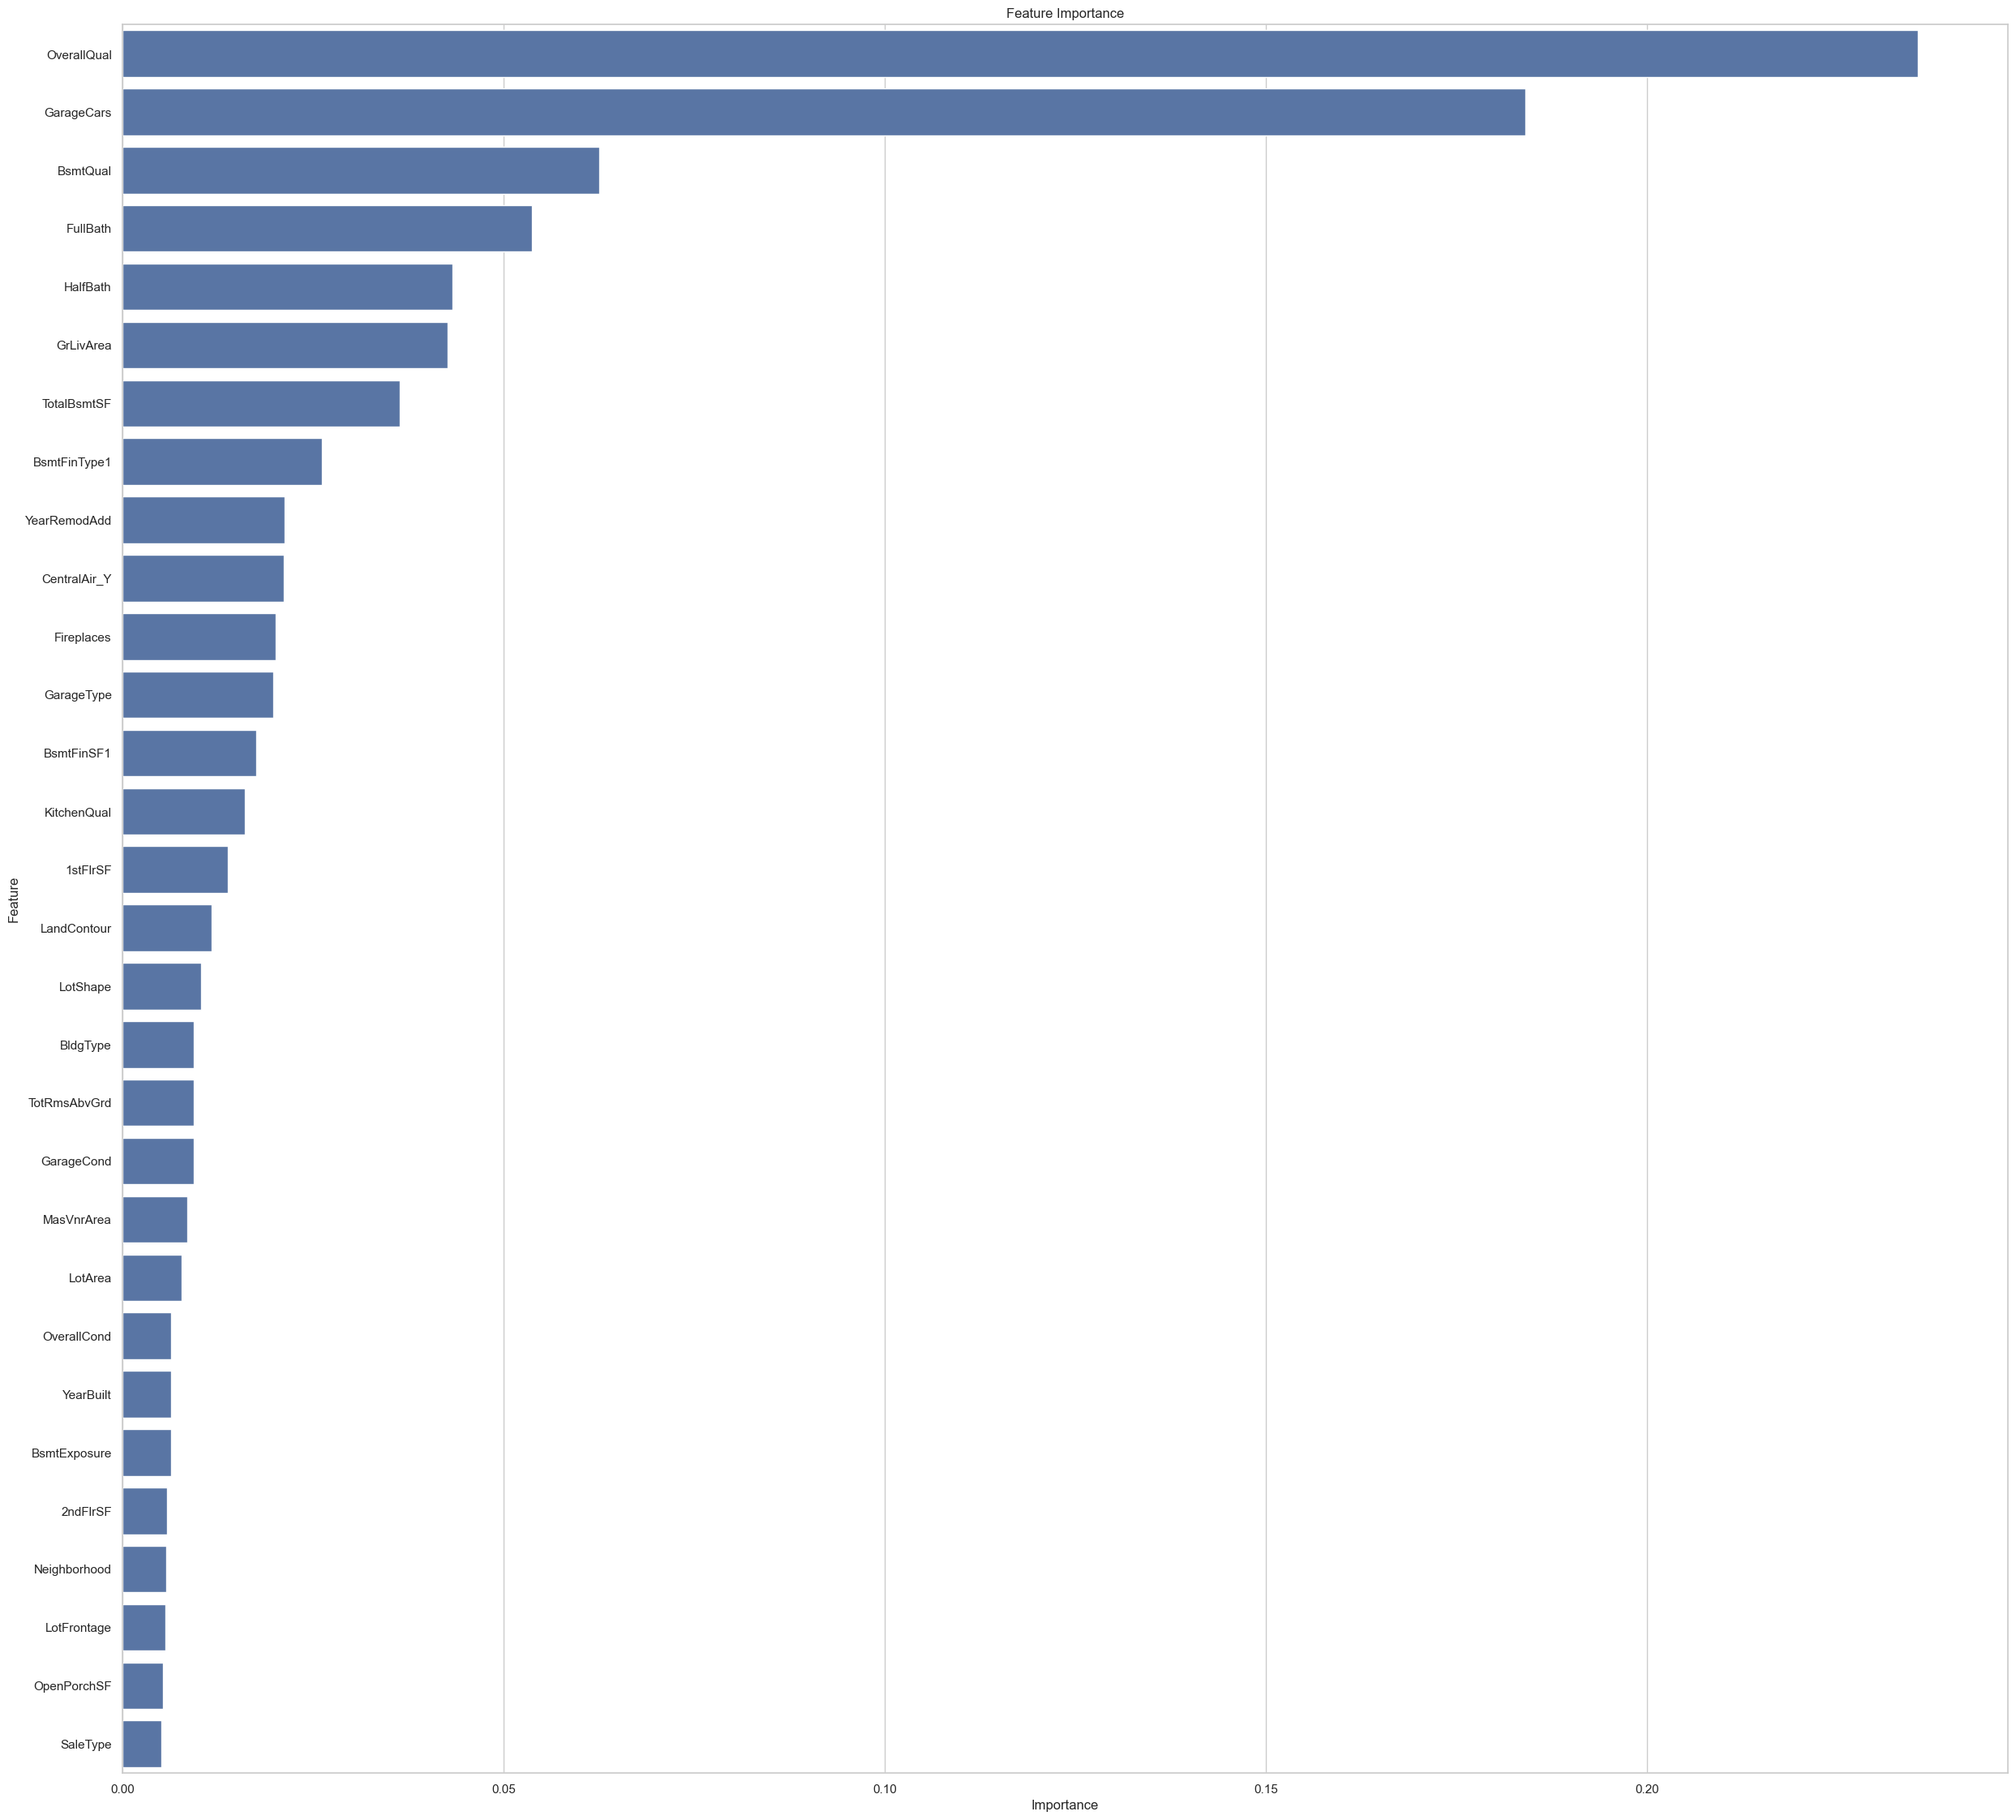

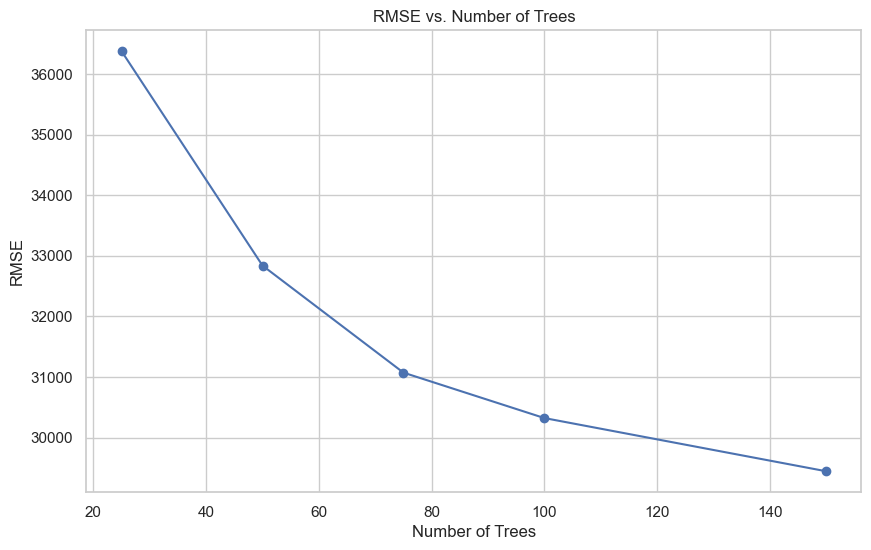

In [42]:
# Instantiate a model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set a parameters grid for a GridSearchCV
params = {'n_estimators': [25, 50, 75, 100, 150],
          'learning_rate': [0.1, 0.01, 0.001, 0.0001],
          'max_depth': range(3, 8)
          }

# Train the model
xgb_model_best = train_tree_model(X, y, xgb_model, params)

<Axes: >

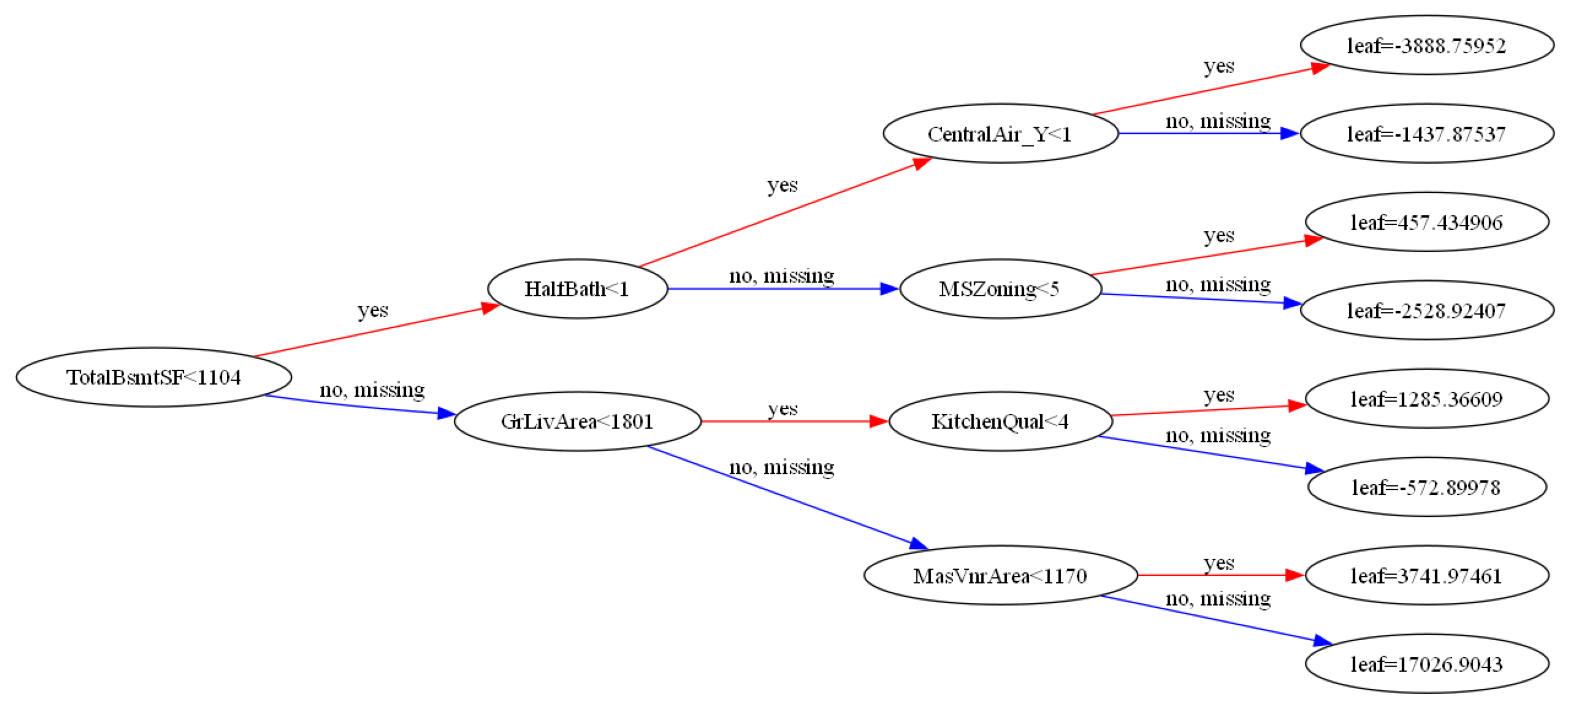

In [43]:
# Plot 15th decision tree of the XGBoost model
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_tree(xgb_model_best, num_trees=15, rankdir='LR', ax=ax)

In [44]:
# Predictions on the test data using the best model:
test_predictions = xgb_model_best.predict(X_test)
submission = pd.DataFrame({'Id': test['Id'], target_feature: test_predictions})
submission.head()

Id      SalePrice
1460  1461  121724.531250
1461  1462  169781.859375
1462  1463  183681.906250
1463  1464  189260.312500
1464  1465  196771.296875

In [45]:
# Create a submission file:
submission.to_csv('data/submission.csv', index=False)